# Train Model to play Cartpole Game (CNN)
- [CNN 1 Frame](#cnn-1-frame)
- [CNN 2 Frame](#cnn-2-frame)
- [CNN 5 Frame + RL](#cnn-5-frame-+-rl)
- [CNN 4 Frame + RL](#cnn-4-frame-+-rl)

## Imports

In [3]:
import sys
import gymnasium # 0.29.1
import cv2 # 4.8.1
import numpy as np # 1.23.4
import PIL # 10.1.0
import tensorflow as tf # 2.13.0
import sklearn as sk # 1.3.2

from PIL import Image
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv3D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

print(sys.version[0:7])
print(gymnasium.__version__)
print(cv2.__version__)
print(np.__version__)
print(PIL.__version__)
print(tf.__version__)
print(sk.__version__)

3.8.18 
0.29.1
4.8.1
1.23.4
10.1.0
2.13.0
1.3.2


## Functions

In [4]:
def preprocess_frame(frame):
    # Resize frame if needed
    frame = cv2.resize(frame, (84, 84))
    # Convert to grayscale
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Normalize pixel values
    frame = frame / 255.0
    # return
    return frame


def get_preprocessed_frame(env):
    """
    Takes a screenshot from the game using `env.render()` and preprocesses it like the following
    - resizing it to (84, 84)
    - grayscaling it
    - normalizing the pixel values

    Returns
    - numpy.ndarray
    """
    # get screenshot of the game
    frame = env.render()
    # preprocess frame
    frame_preprocessed = preprocess_frame(frame)
    # return
    return frame_preprocessed


def action_to_str(action):
    if action == 0:
        return "left"
    else:
        return "right"

## Define Environment

In [5]:
# Define Environment
# - we need render mode as rgb_array to get the values of the screen as np array
env = gymnasium.make("CartPole-v1", render_mode="rgb_array")

## Create CNN Model

In [399]:
# Q-network parameters
action_size = env.action_space.n

# Q-network
model = Sequential()
model.add(Conv2D(32, (3, 3), strides=(1, 1),
          activation='relu', input_shape=(84, 84, 1)))
model.add(Conv2D(64, (4, 4), strides=(1, 1), activation='relu'))
model.add(Conv2D(64, (5, 5), strides=(1, 1), activation='relu'))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(action_size, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=Adam(
    learning_rate=0.001), metrics=['accuracy'])

## Collect Data (Random Agent)
To collect data I will run the training loop with a random agent, and make images along the way from each frame.

In [148]:
# Training parameters
episodes = 5  # amount of times we try to beat the game
gamma = 0.1  # Discount factor
exploration_rate = 1  # Exploration rate
epsilon_decay = 0
avg_score = 0

# Main training loop
for episode in range(episodes):
    # reset run
    state = env.reset()
    score = 0
    episode+=1
    # game loop
    for i in range(500):
        # GET STATE
        # get state - in this case 1 frame of the game
        state = get_preprocessed_frame(env=env)
        image_array = state.astype(np.uint8)
        plt.imsave(f'./data2/run_{episode}/image_{episode}_{i}.png', image_array)

        # GET ACTION
        action = env.action_space.sample()  # Explore

        # DO ACTION
        _, reward, dead, info, truncated = env.step(action)

        # Final stuff
        score+=1
        if dead:
            break
    # print score
    print(f'Episode:{episode} Score:{score}')
    avg_score += score
# print average score
print(avg_score/episodes)
env.close()

Episode:1 Score:17
Episode:2 Score:19
Episode:3 Score:42
Episode:4 Score:15


FileNotFoundError: [Errno 2] No such file or directory: './data2/run_5/image_5_0.png'

# <div style='background-color:yellow;font-size:80px;color:black;text-align:center;padding-top:10px;padding-bottom:10px'>CNN 1 Frame</div>

- Trained for 40 epochs (different data split each 10 epochs)
- Tested on 100 episodes
- Average Score: 24.89
- Max Score: 50

## Sample the Data

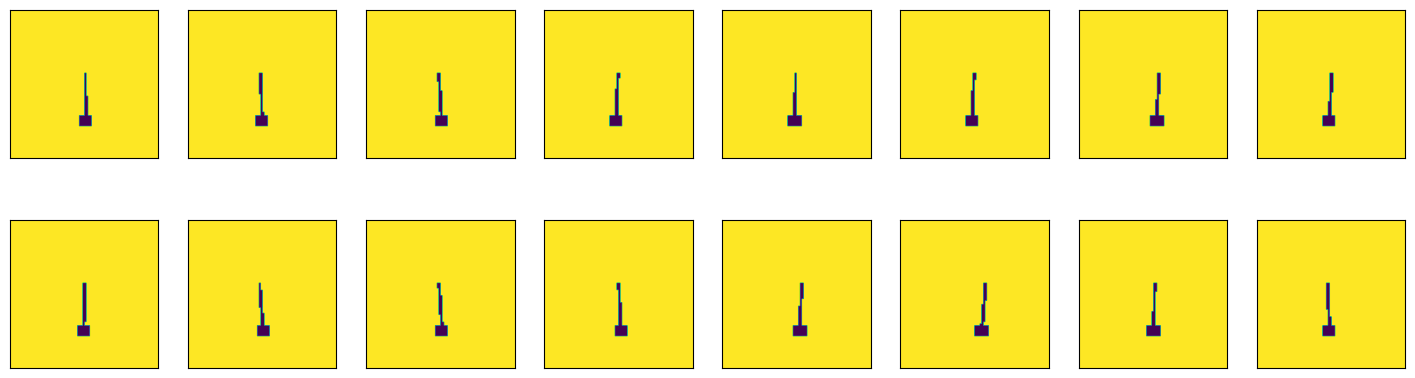

In [109]:
import os
import math
import copy
IMG_SIZE = 84
SAMPLE_SIZE = 16


def ugh(file_path):
    pil_img = Image.open(file_path)
    np_img = np.array(pil_img)
    prep_img = preprocess_frame(np_img)
    return prep_img


np_img_array = []
labels = []
folder_path = './data/0/'
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    prep_img = ugh(file_path)
    np_img_array.append(prep_img)
    labels.append([1, 0])
folder_path = './data/1/'
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    prep_img = ugh(file_path)
    np_img_array.append(prep_img)
    labels.append([0, 1])
np_img_array = np.array(np_img_array)
labels = np.array(labels)



plotimgs = copy.deepcopy(np_img_array)
np.random.shuffle(plotimgs)
rows = plotimgs[:SAMPLE_SIZE]



_, subplots = plt.subplots(nrows=math.ceil(
    SAMPLE_SIZE/8), ncols=8, figsize=(18, int(SAMPLE_SIZE/3)))
subplots = subplots.flatten()
for i, x in enumerate(rows):
    subplots[i].imshow(np.reshape(x, [IMG_SIZE, IMG_SIZE, 1]))
    subplots[i].set_xticks([])
    subplots[i].set_yticks([])

## Train Test Split

In [135]:
from sklearn.model_selection import train_test_split

episode_frame_stacks, X_test, y_train, y_test = train_test_split(np_img_array, labels, test_size=.2)

## Train Model

In [136]:
model.fit(x=episode_frame_stacks, y=y_train, epochs=10, batch_size=32)

Epoch 1/10
4/4 [==============================] - 10s 2s/step - loss: 4.5681 - accuracy: 0.4679
Epoch 2/10
4/4 [==============================] - 8s 2s/step - loss: 0.7269 - accuracy: 0.4862
Epoch 3/10
4/4 [==============================] - 8s 2s/step - loss: 0.8733 - accuracy: 0.5505
Epoch 4/10
4/4 [==============================] - 8s 2s/step - loss: 0.6512 - accuracy: 0.6330
Epoch 5/10
4/4 [==============================] - 8s 2s/step - loss: 0.5742 - accuracy: 0.6972
Epoch 6/10
4/4 [==============================] - 9s 2s/step - loss: 0.6776 - accuracy: 0.7339
Epoch 7/10
4/4 [==============================] - 9s 2s/step - loss: 0.3971 - accuracy: 0.8991
Epoch 8/10
4/4 [==============================] - 9s 2s/step - loss: 0.2919 - accuracy: 0.8991
Epoch 9/10
4/4 [==============================] - 9s 2s/step - loss: 0.1688 - accuracy: 0.9358
Epoch 10/10
4/4 [==============================] - 9s 2s/step - loss: 0.0923 - accuracy: 0.9633


## Test Model

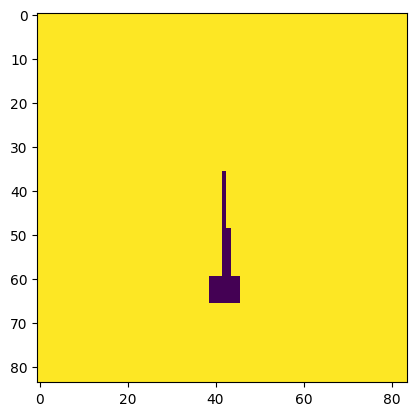

In [140]:
plt.imshow(X_test[2])

## Testing Loop (1 Frame)

In [151]:
# Training parameters
episodes = 100  # amount of times we try to beat the game
gamma = 0.1  # Discount factor
exploration_rate = 0  # Exploration rate
epsilon_decay = 0
avg_score = 0
scores=[]

# Main training loop
for episode in range(episodes):
    # reset run
    state = env.reset()
    score = 0

    # game loop
    while True:
        # get state - in this case 1 frame of the game
        state = get_preprocessed_frame(env=env)

        # GET ACTION
        q_values = model.predict(np.reshape(state, (1, 84, 84, 1)))
        action = np.argmax(q_values)  # Exploit

        # DO ACTION
        _, reward, dead, info, truncated = env.step(action)
        
        # +1 score
        score += 1
        if dead:
            break
    # print score
    print(f'Episode:{episode} Score:{score}')
    avg_score += score
    scores.append(score)

# print average score
print(avg_score/episodes)
print(np.max(scores))
env.close()

1/1 [==============================] - 0s 88ms/step
Episode:0 Score:29
1/1 [==============================] - 0s 88ms/step
Episode:1 Score:10
1/1 [==============================] - 0s 109ms/step
Episode:2 Score:16
1/1 [==============================] - 0s 93ms/step
Episode:3 Score:49
1/1 [==============================] - 0s 94ms/step
Episode:4 Score:42
1/1 [==============================] - 0s 88ms/step
Episode:5 Score:29
1/1 [==============================] - 0s 97ms/step
Episode:6 Score:10
1/1 [==============================] - 0s 90ms/step
Episode:7 Score:36
1/1 [==============================] - 0s 91ms/step
Episode:8 Score:27
1/1 [==============================] - 0s 88ms/step
Episode:9 Score:25
1/1 [==============================] - 0s 88ms/step
Episode:10 Score:13
1/1 [==============================] - 0s 88ms/step
Episode:11 Score:13
1/1 [==============================] - 0s 90ms/step
Episode:12 Score:33
1/1 [==============================] - 0s 87ms/step
Episode:13 Score:21
1

## Save Model

In [157]:
model.save('./models/1-frame')

INFO:tensorflow:Assets written to: ./models/1-frame\assets


INFO:tensorflow:Assets written to: ./models/1-frame\assets


# <div style='background-color:yellow;font-size:80px;color:black;text-align:center;padding-top:10px;padding-bottom:10px'>CNN 2 Frame</div>

First Attempt
- Trained for 40 epochs (different data split each 10 epochs)
- Tested on 100 episodes
- Average Score: 18.65
- Max Score: 56

Second Attempt
- Trained for 60 epochs (different data split each 10 epochs)
- Tested on 100 episodes
- Average Score: 20.81
- Max Score: 55

Third Attempt
- Trained for 80 epochs (different data split each 10 epochs)
- Tested on 100 episodes
- Average Score: 29.24
- Max Score: 54

Conclusion
- The more epochs we train on, the more consistent the model gets.
- The highest score the model can get is around 55. This happens because the model keeps giving the bar too hard of a swing which can't be recovered. To get a higher score we need to input more frames together.

## Create Model

In [527]:
# Q-network parameters
action_size = env.action_space.n

# Q-network
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), strides=(1, 1),activation='relu', input_shape=(84, 84, 2)))
model2.add(Conv2D(64, (4, 4), strides=(1, 1),activation='relu'))
model2.add(Conv2D(64, (5, 5), strides=(1, 1),activation='relu'))
model2.add(Flatten())
model2.add(Dense(512, activation='relu'))
model2.add(Dense(action_size, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

## Load Images
Load in all images into `np_img_array`

In [528]:
import os
import math
import copy
IMG_SIZE = 84
SAMPLE_SIZE = 16

np_img_array = []
labels = []
folder_path = './data2/run_3/'
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    pil_img = Image.open(file_path)
    np_img = np.array(pil_img)
    prep_img = preprocess_frame(np_img)
    np_img_array.append(prep_img)
np_img_array = np.array(np_img_array)

## Pair Images

In [529]:
print(len(np_img_array))
img_pairs=[]
for i, img_ar in enumerate(np_img_array):
    try:
        # this code puts image 2 behind image 1
        image1 = np_img_array[i]
        print(image1.shape)
        image2 = np_img_array[i+1]
        print(image2.shape)
        concatenated_img = np.stack([image1, image2], axis=2)
        img_pairs.append(concatenated_img)
        print('---------')
    except:
        ...
img_pairs = np.array(img_pairs)
print(len(img_pairs))

38
(84, 84)
(84, 84)
---------
(84, 84)
(84, 84)
---------
(84, 84)
(84, 84)
---------
(84, 84)
(84, 84)
---------
(84, 84)
(84, 84)
---------
(84, 84)
(84, 84)
---------
(84, 84)
(84, 84)
---------
(84, 84)
(84, 84)
---------
(84, 84)
(84, 84)
---------
(84, 84)
(84, 84)
---------
(84, 84)
(84, 84)
---------
(84, 84)
(84, 84)
---------
(84, 84)
(84, 84)
---------
(84, 84)
(84, 84)
---------
(84, 84)
(84, 84)
---------
(84, 84)
(84, 84)
---------
(84, 84)
(84, 84)
---------
(84, 84)
(84, 84)
---------
(84, 84)
(84, 84)
---------
(84, 84)
(84, 84)
---------
(84, 84)
(84, 84)
---------
(84, 84)
(84, 84)
---------
(84, 84)
(84, 84)
---------
(84, 84)
(84, 84)
---------
(84, 84)
(84, 84)
---------
(84, 84)
(84, 84)
---------
(84, 84)
(84, 84)
---------
(84, 84)
(84, 84)
---------
(84, 84)
(84, 84)
---------
(84, 84)
(84, 84)
---------
(84, 84)
(84, 84)
---------
(84, 84)
(84, 84)
---------
(84, 84)
(84, 84)
---------
(84, 84)
(84, 84)
---------
(84, 84)
(84, 84)
---------
(84, 84)
(84, 84)

(37, 84, 84, 2)


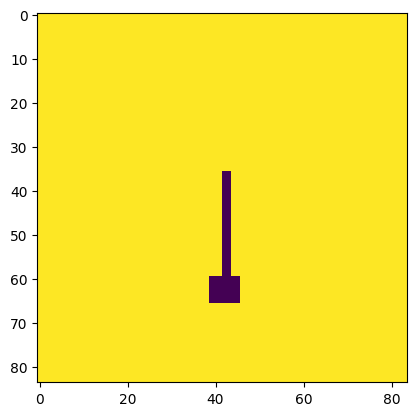

In [ ]:
print(img_pairs.shape)
plt.imshow(img_pairs[0][:,:,0])

(37, 84, 84, 2)


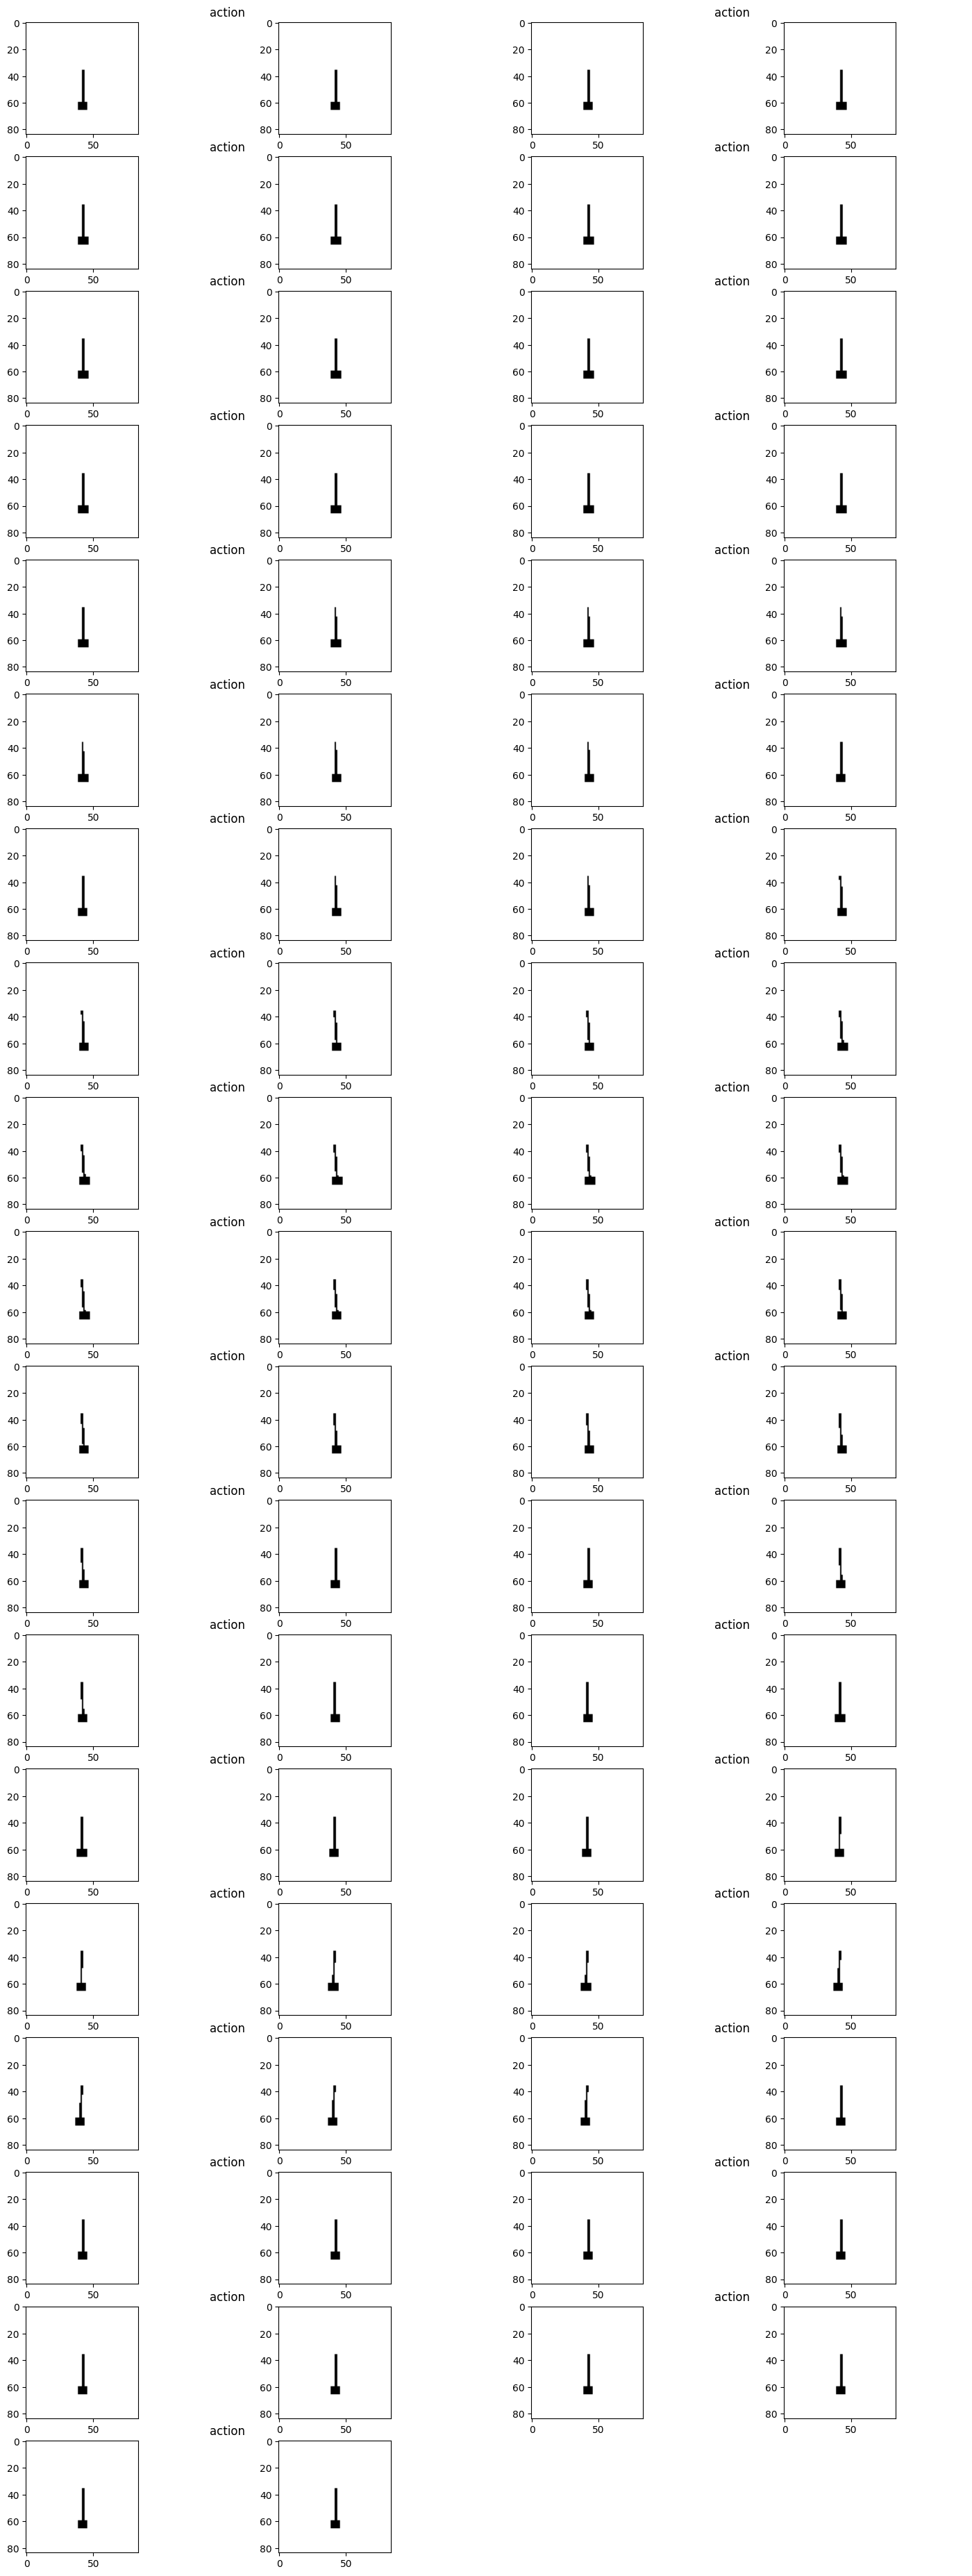

In [395]:
print(img_pairs.shape)

plt.figure(figsize=(18, 80))
for i in range(len(img_pairs)):
    plt.subplot(32, 4, 2*i+1)
    plt.imshow(img_pairs[i][:,:,0], cmap='gray')
    plt.subplot(32, 4, 2*i+2)
    plt.imshow(img_pairs[i][:,:,1], cmap='gray')
    plt.title('action                                                           ')
plt.show()


## Label them Manually

In [531]:
# 37 data
print(len(img_pairs))
pair_labels = [[0,1], [1,0], [0,1], [1,0], [0,1], [1,0], [0,1], [1,0], [1,0], [1, 0], [1, 0], [0, 1], [1, 0], [1,0], [1,0], [1,0], [1,0], [1,0], [1,0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1]]
print(len(pair_labels))
pair_labels = np.array(pair_labels)

37
37


## Train Test Split

In [554]:
from sklearn.model_selection import train_test_split

episode_frame_stacks, X_test, y_train, y_test = train_test_split(img_pairs, pair_labels, test_size=.2)

## Verify Types

In [555]:
print(episode_frame_stacks.shape)
print(type(episode_frame_stacks))
print(y_train.shape)
print(type(y_train))

(29, 84, 84, 2)
<class 'numpy.ndarray'>
(29, 2)
<class 'numpy.ndarray'>


## Train Model

In [556]:
model2.fit(x=episode_frame_stacks, y=y_train, epochs=10, batch_size=32)

Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 0.1448 - accuracy: 0.8966
Epoch 2/10
1/1 [==============================] - 4s 4s/step - loss: 0.1510 - accuracy: 0.9310
Epoch 3/10
1/1 [==============================] - 4s 4s/step - loss: 0.1454 - accuracy: 0.9310
Epoch 4/10
1/1 [==============================] - 4s 4s/step - loss: 0.1300 - accuracy: 0.9310
Epoch 5/10
1/1 [==============================] - 4s 4s/step - loss: 0.1407 - accuracy: 0.8966
Epoch 6/10
1/1 [==============================] - 4s 4s/step - loss: 0.1292 - accuracy: 0.9310
Epoch 7/10
1/1 [==============================] - 4s 4s/step - loss: 0.1319 - accuracy: 0.9310
Epoch 8/10
1/1 [==============================] - 4s 4s/step - loss: 0.1319 - accuracy: 0.9310
Epoch 9/10
1/1 [==============================] - 4s 4s/step - loss: 0.1258 - accuracy: 0.9310
Epoch 10/10
1/1 [==============================] - 4s 4s/step - loss: 0.1296 - accuracy: 0.9310


## Test Model

In [419]:
predictions = model2.predict(X_test)

1/1 [==============================] - 0s 428ms/step


## Evaluate Prediction
I am happy with the results :D

chosen action: right
chosen action: right
chosen action: left
chosen action: left


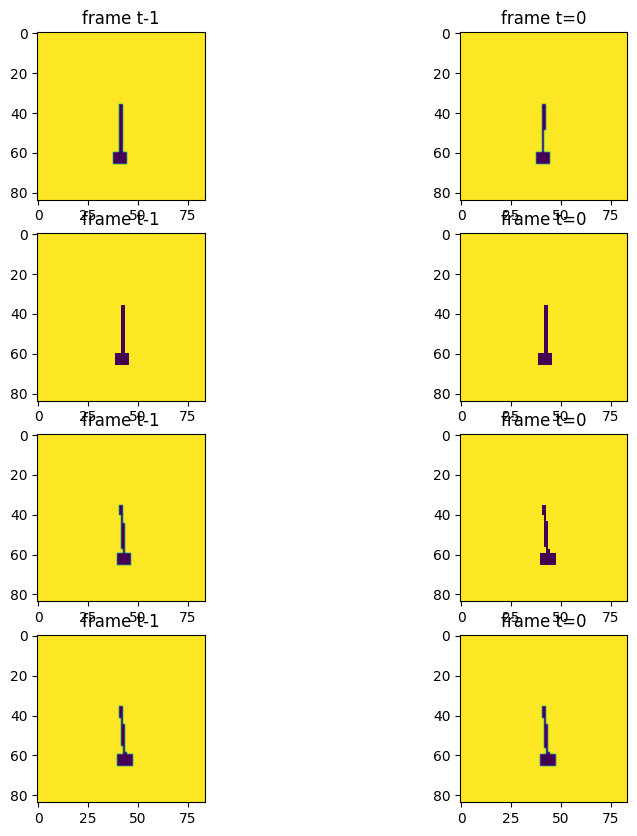

In [442]:
plt.figure(figsize=(10, 10))
for i in range(4):
    image = X_test[i]
    action = np.argmax(predictions[i])
    plt.subplot(4, 2, i*2+1)
    plt.imshow(image[:, :, 0])
    plt.title("frame t-1")
    plt.subplot(4, 2, i*2+2)
    plt.imshow(image[:, :, 1])
    plt.title("frame t=0")
    print(f'chosen action: {action_to_str(action)}')

## Test Loop (2 Frames)

In [557]:
def add_frame_to_frame_stack(frame_stack, new_frame):
    """Move `frame_stack[:,:,1]` to `frame_stack[:,:,0]`. Next put `new_frame` in `frame_stack[:,:,1]`"""
    frame_stack[:, :, 0] = frame_stack[:, :, 1]
    frame_stack[:, :, 1] = new_frame
    return frame_stack

# Training parameters
episodes = 100  # amount of times we try to beat the game
gamma = 0.1  # Discount factor
exploration_rate = 0  # Exploration rate
epsilon_decay = 0
avg_score = 0
scores=[]



frame_stack = np.stack([np.random.random((84, 84)), np.random.random((84, 84))], axis=2)

# Main training loop
for episode in range(episodes):
    # reset run
    state = env.reset()
    state = get_preprocessed_frame(env=env)
    frame_stack = add_frame_to_frame_stack(frame_stack=frame_stack, new_frame=state)
    score = 0
    

    # game loop
    while True:
        # GET STATE
        state = get_preprocessed_frame(env=env)
        # add frame to frame stack
        frame_stack = add_frame_to_frame_stack(frame_stack=frame_stack, new_frame=state)
        # preprocess state
        frame_stack_copy = frame_stack.copy()
        # add dimention to shape so the model can make a prediction. (without this step the model will get a shape error becayse there is no batch, this code makes batch=1)
        frame_stack_copy = np.expand_dims(frame_stack_copy, axis=0)

        # GET ACTION
        q_values = model2.predict(frame_stack_copy)
        # extract best action
        action = np.argmax(q_values)

        # DO ACTION
        _, reward, dead, info, truncated = env.step(action)
        
        # +1 score
        score += 1
        if dead:
            break
    # print score
    print(f'Episode:{episode} Score:{score}')
    avg_score += score
    scores.append(score)

# print average score
print(f"Average Score: {avg_score/episodes}")
print(f"Max Score: {np.max(scores)}")
env.close()

1/1 [==============================] - 0s 136ms/step
Episode:0 Score:11
1/1 [==============================] - 0s 132ms/step
Episode:1 Score:28
1/1 [==============================] - 0s 132ms/step
Episode:2 Score:29
1/1 [==============================] - 0s 128ms/step
Episode:3 Score:25
1/1 [==============================] - 0s 118ms/step
Episode:4 Score:36
1/1 [==============================] - 0s 148ms/step
Episode:5 Score:12
1/1 [==============================] - 0s 116ms/step
Episode:6 Score:39
1/1 [==============================] - 0s 120ms/step
Episode:7 Score:34
1/1 [==============================] - 0s 120ms/step
Episode:8 Score:26
1/1 [==============================] - 0s 116ms/step
Episode:9 Score:26
1/1 [==============================] - 0s 120ms/step
Episode:10 Score:54
1/1 [==============================] - 0s 120ms/step
Episode:11 Score:20
1/1 [==============================] - 0s 116ms/step
Episode:12 Score:38
1/1 [==============================] - 0s 116ms/step
Episode:

## Check where it goes wrong
I outputted the images to a folder and also outputted the actions. whenever the pole started falling over to the right it moved left for 5 consecutive frames, but it had no use. that is because it was holding right for 12 frames right before that. it builds a too high velocity that ruins it for future frames. To solve this i am gonna try to give the model more frames.

27 frame run

<img src='./data2/evaluate_0/cartpole.gif'>

## Save Model

In [558]:
model.save('./models/2-frame')

INFO:tensorflow:Assets written to: ./models/2-frame\assets


INFO:tensorflow:Assets written to: ./models/2-frame\assets


# <div style='background-color:yellow;font-size:80px;color:black;text-align:center;padding-top:10px;padding-bottom:10px'>CNN 5 Frame + RL</div>

now we are gonna make it learn during play, to do this we do the following
- crank up exploration rate, learn 5 frames bacak in time, so that we dont learn stuff that makes us die
- if enough learned, we test

First Attempt
- Trained for 186 epochs (episode data + all earlier episodes data -> 2 epochs (this was done by mistake))
- Tested on 100 episodes
- Average Score: 21.7
- Max Score: 88

Second Attempt
- Trained for 682 epochs (episode data first 2 epochs per episode, later on 1 epoch per episode)
- Tested on 100 episodes
- Average Score: 9.3
- Max Score: 11

Third Attempt
- Trained for 1576 epochs (episode data first 2 epochs per episode, later on 1 epoch per episode)
- Tested on 100 episodes
- Average Score: 9.4
- Max Score: 11

## Create Model

In [721]:
# Q-network parameters
action_size = env.action_space.n

# size, size, amount of frames stacked
input_shape = (84, 84, 5)

# Q-network
model3 = Sequential()
model3.add(Conv2D(32, (3, 3), strides=(1, 1),activation='relu', input_shape=input_shape))
model3.add(Conv2D(64, (4, 4), strides=(1, 1), activation='relu'))
model3.add(Conv2D(64, (5, 5), strides=(1, 1), activation='relu'))
model3.add(Flatten())
model3.add(Dense(512, activation='relu'))
model3.add(Dense(action_size, activation='sigmoid'))
model3.compile(loss='binary_crossentropy', optimizer=Adam(
    learning_rate=0.001), metrics=['accuracy'])

## Some Functions
Since we start using RL now we need a bit more

In [9]:
def one_hot_encode_action(num):
    if num == 0:
        return [1, 0]
    elif num == 1:
        return [0, 1]
    else:
        Exception()



# def add_frame_to_frame_stack(frame_stack, new_frame):
#     """Move `frame_stack[:,:,4]` to `frame_stack[:,:,3]` and move `frame_stack[:,:,3]` to `frame_stack[:,:,2]` etc.. Next put `new_frame` in `frame_stack[:,:,4]`"""
#     frame_stack[:, :, 0] = frame_stack[:, :, 1]
#     frame_stack[:, :, 1] = frame_stack[:, :, 2]
#     frame_stack[:, :, 2] = frame_stack[:, :, 3]
#     frame_stack[:, :, 3] = frame_stack[:, :, 4]
#     frame_stack[:, :, 4] = new_frame
#     return frame_stack

# def add_action_to_action_stack(action_stack, new_action):
#     action_stack[0] = action_stack[1]
#     action_stack[1] = action_stack[2]
#     action_stack[2] = action_stack[3]
#     action_stack[3] = action_stack[4]
#     action_stack[4] = new_action

## Train Model
To train my model i came up with the following methodology
- Play the game with random inputs (basically the same as exploration_rate=1)
- We collect all the frames and actions of an episode
- After an episode we check our score, if we have a score more than 11, we have enough data/frames to learn
- we cut off the last 6 frames since they resulted in us dying and we dont want to learn something that kills us.
- use all frames and actions to prepare an `X_train` and `y_train` and train the model
- This way we train the model after each episode. after we have done this a couple of times, we can use the model and make it train simultaneosly
- This might seem very sketch, i have my theories plotted out below the code block.

In [758]:
# Training parameters
episodes = 500  # amount of times we try to beat the game // 50 might be enough
exploration_rate = 1  # Exploration rate - We don't need this because during this training loop we will always sample and do random actions
avg_score = 0
scores = []
X_train=None


img1 = np.random.random((84, 84))
img2 = np.random.random((84, 84))
img3 = np.random.random((84, 84))
img4 = np.random.random((84, 84))
img5 = np.random.random((84, 84))
frame_stack = np.stack([img1, img2, img3, img4, img5], axis=2)

# Main training loop
for episode in range(episodes):
    # reset run
    episode_frames = [] # all frames of a single episode
    episode_actions = [] # all actions of a single episode
    state = env.reset()
    state = get_preprocessed_frame(env=env)
    score = 0

    # game loop - when the game loop starts score=0. we use score to see in which frame we currently are. So score>4 means if we are on the 6th frame of the game 
    while True:
        # first we need to make sure the frame_stack and action_stack both have their queue filled up.
        # GET STATE
        # preprocess state 
        state = get_preprocessed_frame(env=env)
        episode_frames.append(state)

        # GET ACTION
        action = env.action_space.sample()
        episode_actions.append(action)

        # DO ACTION
        _, reward, dead, info, truncated = env.step(action)
    
        # +1 score
        score += 1
        if dead:
            break

    # if you died and the score was more than 11, the frames and actions will be looked into and learned - Minimum is > 11
    if score>25: # change this to 20
        print(f'Enough score to learn :D ({score})')
        episode_frames = episode_frames[:-6]
        episode_actions = episode_actions[:-6]

        episode_frame_stacks = []
        y_train = []
        for i in range(100):
            try:
                # frame / X_train
                img1 = episode_frames[i]
                img2 = episode_frames[i+1]
                img3 = episode_frames[i+2]
                img4 = episode_frames[i+3]
                img5 = episode_frames[i+4]
                frame_stack = np.stack([img1, img2, img3, img4, img5], axis=2)
                frame_stack = np.expand_dims(frame_stack, axis=0)
                episode_frame_stacks.append(frame_stack)

                # action / y_train
                action5 = episode_actions[i+4]
                action5_one_hot_encoded = one_hot_encode_action(action5)
                y_train.append(action5_one_hot_encoded)
            except:
                break

        # start to learn with x and y train
        # preprocess X_train
        X_train=episode_frame_stacks[0]
        for array in episode_frame_stacks[1:]:
            X_train = np.concatenate([X_train, array], axis=0)
        # preprocess y_train
        y_train = np.array(y_train)
        # verify shapes
        print(X_train.shape)
        print(y_train.shape)
        model3.fit(X_train, y_train, epochs=1, batch_size=32)

    print(f'total frames: {len(episode_frames)}')
    print(f'total actions: {len(episode_actions)}')
    # print score
    print(f'Episode:{episode+1} Score:{score}')
    avg_score += score
    scores.append(score)

# print average score
print(f"Average Score: {avg_score/episodes}")
print(f"Max Score: {np.max(scores)}")
env.close()

X_train
<class 'numpy.ndarray'>
(1, 84, 84, 5)
(30, 84, 84, 5)


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 4 dimension(s) and the array at index 1 has 3 dimension(s)

## Verify my Methodology
I made a plot wherein you can see what the model is wanting to learn. You can see the framestack and the action taken. The last 6 frames are dropped because we dont want to learn anything which could kill us. Overall this gives me a confident feeling. Let's start learning

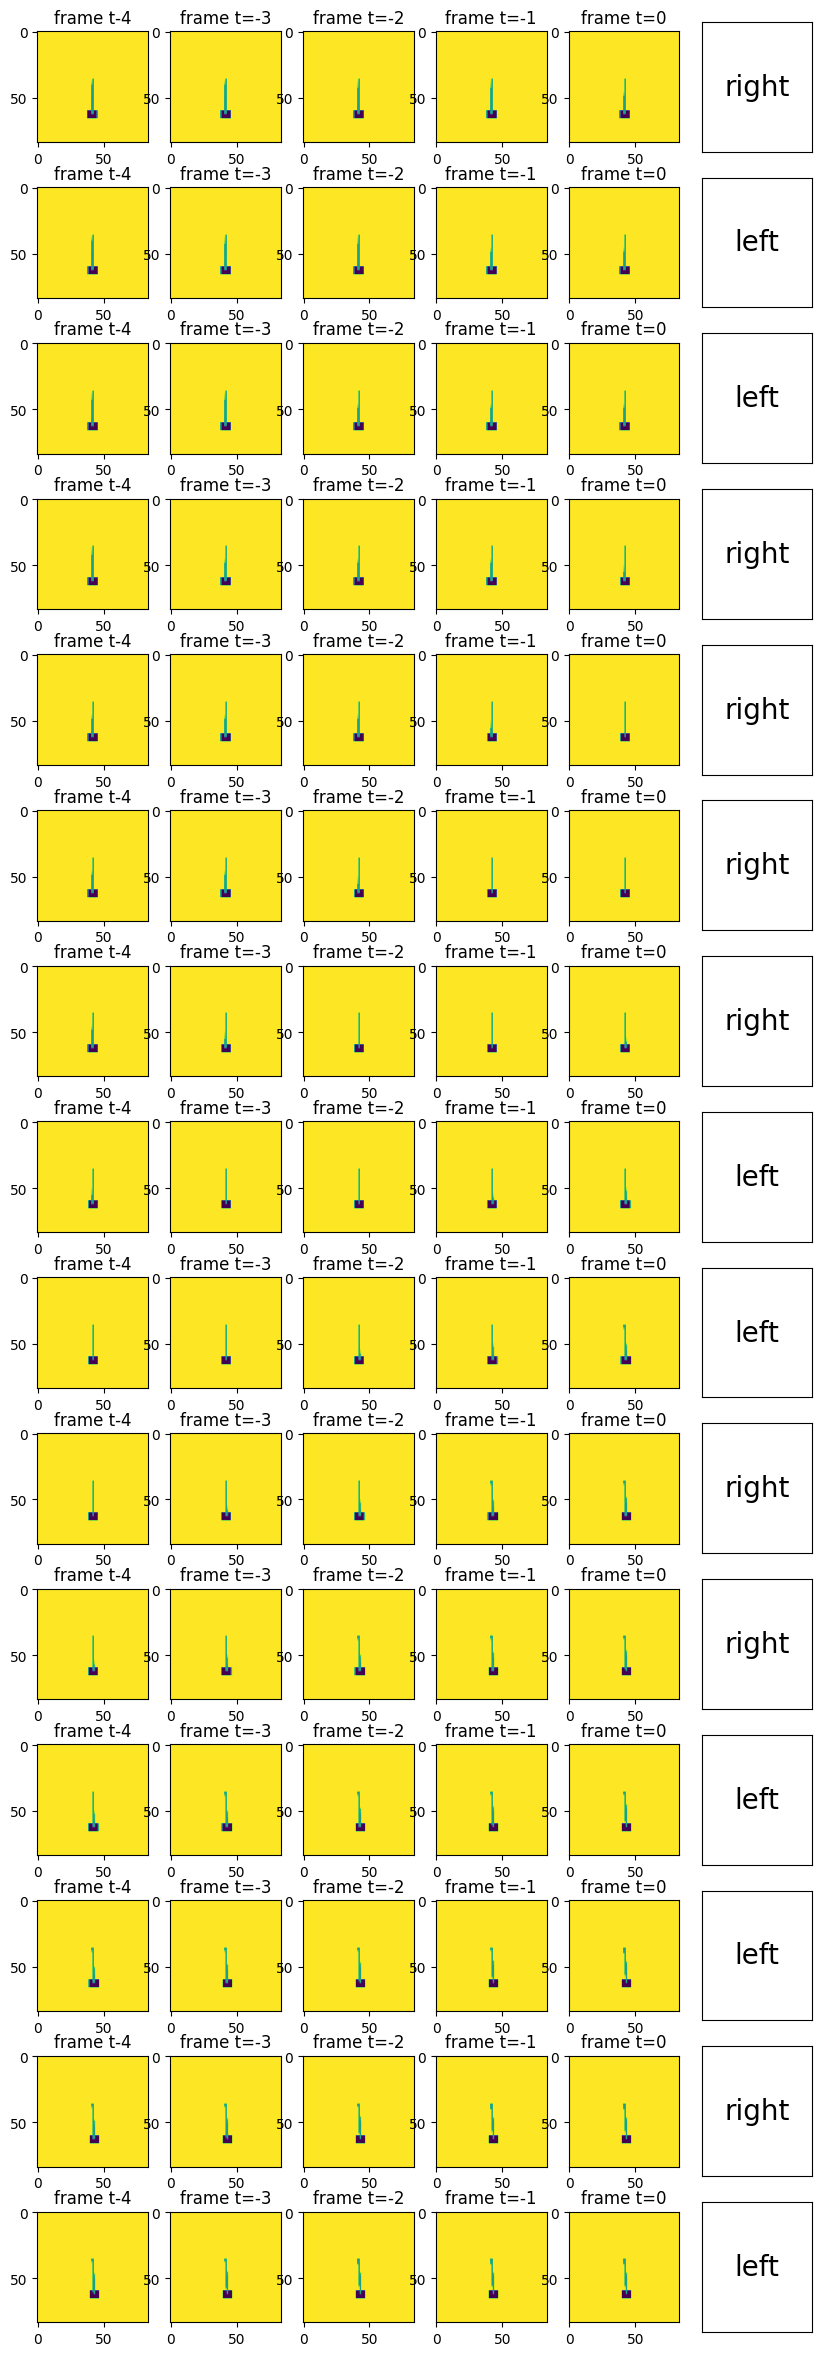

In [659]:
rows = 15
cols = 6
plt.figure(figsize=(10, rows*2))
for i in range(15):
    image = X_train[i]
    action = y_train[i]
    plt.subplot(rows, cols, i*cols+1)
    plt.imshow(image[:, :, 0])
    plt.title("frame t=-4")

    plt.subplot(rows, cols, i*cols+2)
    plt.imshow(image[:, :, 1])
    plt.title("frame t=-3")

    plt.subplot(rows, cols, i*cols+3)
    plt.imshow(image[:, :, 2])
    plt.title("frame t=-2")

    plt.subplot(rows, cols, i*cols+4)
    plt.imshow(image[:, :, 3])
    plt.title("frame t=-1")

    plt.subplot(rows, cols, i*cols+5)
    plt.imshow(image[:, :, 4])
    plt.title("frame t=0")

    # Create a subplot with a single plot
    plt.subplot(rows, cols, i*cols+6)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.text(0.5, 0.5, action_to_str(
        episode_actions[i]), fontsize=20, ha='center', va='center')
    plt.xticks([])
    plt.yticks([])

## Test Model

In [718]:
print(X_train.shape)
print(y_train.shape)
r_train = X_train[9]
r_train = np.expand_dims(r_train, axis=0)
r_train.shape
model3.predict(r_train)

(29, 84, 84, 5)
(29, 2)
1/1 [==============================] - 0s 218ms/step


array([[0.50197625, 0.49790236]], dtype=float32)

## Evaluate Predictions
Here i test my 1800+ epochs model, the action chosen is bad

(84, 84, 5)


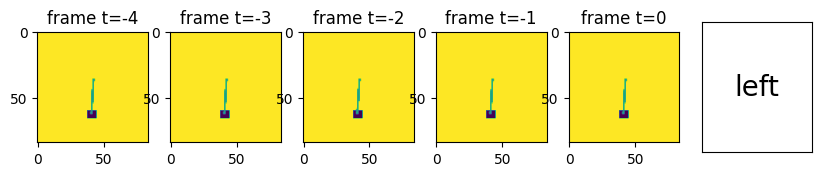

In [719]:
r_train = X_train[9]
print(r_train.shape)

rows = 15
cols = 6
plt.figure(figsize=(10, rows*2))
for i in range(1):
    image = r_train
    action = y_train[i]
    plt.subplot(rows, cols, i*cols+1)
    plt.imshow(image[:, :, 0])
    plt.title("frame t=-4")
    plt.subplot(rows, cols, i*cols+2)
    plt.imshow(image[:, :, 1])
    plt.title("frame t=-3")
    plt.subplot(rows, cols, i*cols+3)
    plt.imshow(image[:, :, 2])
    plt.title("frame t=-2")
    plt.subplot(rows, cols, i*cols+4)
    plt.imshow(image[:, :, 3])
    plt.title("frame t=-1")
    plt.subplot(rows, cols, i*cols+5)
    plt.imshow(image[:, :, 4])
    plt.title("frame t=0")
    plt.subplot(rows, cols, i*cols+6)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.text(0.5, 0.5, action_to_str(episode_actions[i]), fontsize=20, ha='center', va='center')
    plt.xticks([])
    plt.yticks([])

## Test Loop
THIS IS THE TEST 

In [720]:
# Training parameters
episodes = 100  # amount of times we try to beat the game // 50 might be enough
gamma = 0.1  # Discount factor
exploration_rate = 1  # Exploration rate - We don't need this because during this training loop we will always sample and do random actions
epsilon_decay = 0
avg_score = 0
scores = []
X_train = None


img1 = np.random.random((84, 84))
img2 = np.random.random((84, 84))
img3 = np.random.random((84, 84))
img4 = np.random.random((84, 84))
img5 = np.random.random((84, 84))
frame_stack = np.stack([img1, img2, img3, img4, img5], axis=2)
episode_frames = []  # all frames of a single episode
episode_actions = []  # all actions of a single episode

# Main training loop
for episode in range(episodes):
    # reset run
    state = env.reset()
    state = get_preprocessed_frame(env=env)
    frame_stack = add_frame_to_frame_stack(frame_stack=frame_stack, new_frame=state)
    frame_stack = add_frame_to_frame_stack(frame_stack=frame_stack, new_frame=state)
    frame_stack = add_frame_to_frame_stack(frame_stack=frame_stack, new_frame=state)
    frame_stack = add_frame_to_frame_stack(frame_stack=frame_stack, new_frame=state)
    score = 0

    # game loop - when the game loop starts score=0. we use score to see in which frame we currently are. So score>4 means if we are on the 6th frame of the game
    while True:
        # first we need to make sure the frame_stack and action_stack both have their queue filled up.
        # GET STATE
        # preprocess state 1/2
        state = get_preprocessed_frame(env=env)
        # add frame to frame stack
        frame_stack = add_frame_to_frame_stack(frame_stack=frame_stack, new_frame=state)
        episode_frames.append(state)
        # preprocess state 2/2
        frame_stack_copy = frame_stack.copy()
        # add dimention to shape so the model can make a prediction. (without this step the model will get a shape error becayse there is no batch, this code makes batch=1)
        frame_stack_copy = np.expand_dims(frame_stack_copy, axis=0)

        # GET ACTION
        # action = env.action_space.sample()
        episode_actions.append(action)
        q_values = model3.predict(frame_stack_copy)
        action = np.argmax(q_values)

        # DO ACTION
        _, reward, dead, info, truncated = env.step(action)

        # +1 score
        score += 1
        if dead:
            break

    print(f'total frames: {len(episode_frames)}')
    print(f'total actions: {len(episode_actions)}')
    # print score
    print(f'Episode:{episode+1} Score:{score}')
    avg_score += score
    scores.append(score)

# print average score
print(f"Average Score: {avg_score/episodes}")
print(f"Max Score: {np.max(scores)}")
env.close()

1/1 [==============================] - 0s 192ms/step
total frames: 9
total actions: 9
Episode:1 Score:9
1/1 [==============================] - 0s 192ms/step
total frames: 17
total actions: 17
Episode:2 Score:8
1/1 [==============================] - 0s 185ms/step
total frames: 25
total actions: 25
Episode:3 Score:8
1/1 [==============================] - 0s 188ms/step
total frames: 35
total actions: 35
Episode:4 Score:10
1/1 [==============================] - 0s 186ms/step
total frames: 44
total actions: 44
Episode:5 Score:9
1/1 [==============================] - 0s 188ms/step
total frames: 54
total actions: 54
Episode:6 Score:10
1/1 [==============================] - 0s 181ms/step
total frames: 63
total actions: 63
Episode:7 Score:9
1/1 [==============================] - 0s 180ms/step
total frames: 71
total actions: 71
Episode:8 Score:8
1/1 [==============================] - 0s 309ms/step
total frames: 80
total actions: 80
Episode:9 Score:9
1/1 [==============================] - 0s 196m

# <div style='background-color:yellow;font-size:80px;color:black;text-align:center;padding-top:10px;padding-bottom:10px'>CNN 4 Frame + RL</div>

Let's take a step back. Let's go with 4 frames. I will still try to feed them together to the model simultaneosly. Main difference now is one frame less and making use of experience replay.

First Attempt
- Trained for 91 epochs (episode data + all earlier episodes data -> 1 epoch after every episode)
- learning_rate = 0.001
- batch_size = 32
- Tested on 100 episodes
- Average Score: 9.3
- Max Score: 11

Second Attempt
- Trained for 25 epochs (episode data + all earlier episodes data, but we take random stacks of data using train test split -> 1 epoch after every episode)
- learning_rate = 0.001
- batch_size = 32
- Tested on 100 episodes
- Average Score: 9.2
- Max Score: 11
- *Note: more complex model*

Third Attempt
- Trained for 90 epochs (episode data + all earlier episodes data, but we take random stacks of data using train test split -> 5 epochs after every episode)
- Extra data collectiong without learning
- Trained for 35 epochs (episode data + all earlier episodes data, but we take random stacks of data using train test split -> 10 epochs after every episode (basically 1k+ framestacks per epoch))
- learning_rate = 0.01
- batch_size = 32
- Tested on 100 episodes
- Average Score: 9.5
- Max Score: 11
- *Note: more complex model*

## Create Model

In [12]:
# Q-network parameters
action_size = env.action_space.n

# # Q-network - OLD MODEL
# model4 = Sequential()
# model4.add(Conv2D(32, (3, 3), strides=(1, 1),activation='relu', input_shape=(84, 84, 4)))
# model4.add(Conv2D(64, (4, 4), strides=(1, 1), activation='relu'))
# model4.add(Conv2D(64, (5, 5), strides=(1, 1), activation='relu'))
# model4.add(Flatten())
# model4.add(Dense(512, activation='relu'))
# model4.add(Dense(action_size, activation='sigmoid'))
# model4.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Q-network
model4 = Sequential()
model4.add(Conv2D(32, (3, 3), strides=(1, 1),activation='relu', input_shape=(84, 84, 4)))
model4.add(Conv2D(64, (4, 4), strides=(1, 1), activation='relu'))
model4.add(Conv2D(64, (5, 5), strides=(1, 1), activation='relu'))
model4.add(Conv2D(64, (6, 6), strides=(1, 1), activation='relu'))
model4.add(Flatten())
model4.add(Dense(512, activation='relu'))
model4.add(Dense(256, activation='relu'))
model4.add(Dense(128, activation='relu'))
model4.add(Dense(action_size, activation='sigmoid'))
model4.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

## Train Model
The idea is
- make the model play with random actions
- learn during play with episode data and earlier collected dataa

In [13]:
# experience replay save
X_train_replay = []
y_train_replay = []

In [19]:
from sklearn.model_selection import train_test_split

# Training parameters
episodes = 150  # amount of times we try to beat the game // 50 might be enough
exploration_rate = 1  # Exploration rate - We don't need this because during this training loop we will always sample and do random actions
avg_score = 0
scores = []
variable_test_size = 0.10

# Main training loop
for episode in range(episodes):
    # reset run
    X_train = None
    y_train = None
    episode_frames = [] # all frames of a single episode
    episode_actions = [] # all actions of a single episode
    state = env.reset()
    state = get_preprocessed_frame(env=env)
    score = 0

    # game loop
    # when the game loop starts score=0. We use score to see in which game frame we currently are. So score>4 means if we are on the 6th frame of the game 
    while True:
        # GET STATE
        # preprocess state
        state = get_preprocessed_frame(env=env)
        # add frame to all frames
        episode_frames.append(state)

        # GET ACTION
        action = env.action_space.sample()
        episode_actions.append(action)

        # DO ACTION
        _, reward, dead, info, truncated = env.step(action)
    
        # +1 score
        score += 1
        if dead:
            break




    # if you died and the score was more than 11, the frames and actions will be looked into and learned - Minimum is > 11
    if score>15: # we will only learn if the score was more than 15
        episode_frames = episode_frames[:-6] # drop last 6 frame stacks
        episode_actions = episode_actions[:-6] # drop last 6 actions

        # put all fraame stacks of this episode in a list & put all actions of this episode in a list
        episode_frame_stacks = [] # framestacks this episode
        y_train = [] # actions this episode
        for i in range(len(episode_frames)-4):
            # form frame stacks from the episode_frames list
            frame_stack = np.stack(
                [episode_frames[i], 
                 episode_frames[i+1], 
                 episode_frames[i+2], 
                 episode_frames[i+3]], axis=2)
            frame_stack = np.expand_dims(frame_stack, axis=0)
            episode_frame_stacks.append(frame_stack)

            # one hot encode the actions of this episode
            action5 = episode_actions[i+3]
            action5_one_hot_encoded = one_hot_encode_action(action5)
            y_train.append(action5_one_hot_encoded)

            


        # Prepare X_train and y_train for training, also prepare experience replay
        # put first frame stack in X_train - X_train needs at least 1 entry before we can concatenate. same applies to X_train_replay
        X_train=episode_frame_stacks[0]
        if len(X_train_replay)==0:
            X_train_replay=episode_frame_stacks[0] # read comment above
        else:
            X_train_replay = np.concatenate([X_train_replay, episode_frame_stacks[0]], axis=0)

        # put all frame stacks inside the X_train's
        for array in episode_frame_stacks[1:]:
            X_train_replay = np.concatenate([X_train_replay, array], axis=0)

        # preprocess y_train
        y_train = np.array(y_train)

        # first give it an entry before we go crazy
        if len(y_train_replay) == 0:
            y_train_replay = y_train
        else:
            y_train_replay = np.concatenate((y_train_replay, y_train))


        # add experience replay data to episode data
        print(f"Before train test split: {X_train_replay.shape} {y_train_replay.shape}")
        # train test split (optional)
        variable_test_size+=0.002
        X_train5, _, y_train5, _ = train_test_split(X_train_replay, y_train_replay, test_size=variable_test_size) 
        print(f"After train test split: {X_train5.shape} {y_train5.shape}")
        print(f'variable_test_size: {variable_test_size}')
        model4.fit(X_train5, y_train5, epochs=10, batch_size=32)

    # print(f'total frames: {len(episode_frames)}')
    # print(f'total actions: {len(episode_actions)}')
    # print score
    print(f'Episode:{episode+1} Score:{score}')
    avg_score += score
    scores.append(score)

# print average score
print(f"Average Score: {avg_score/episodes}")
print(f"Max Score: {np.max(scores)}")
env.close()

Before train test split: (2701, 84, 84, 4) (2701, 2)
After train test split: (2425, 84, 84, 4) (2425, 2)
variable_test_size: 0.10200000000000001
Epoch 1/10
76/76 [==============================] - 203s 3s/step - loss: 0.6934 - accuracy: 0.5060
Epoch 2/10
76/76 [==============================] - 206s 3s/step - loss: 0.6933 - accuracy: 0.4961
Epoch 3/10
76/76 [==============================] - 204s 3s/step - loss: 0.6944 - accuracy: 0.5027
Epoch 4/10
76/76 [==============================] - 205s 3s/step - loss: 0.6935 - accuracy: 0.5014
Epoch 5/10
76/76 [==============================] - 205s 3s/step - loss: 0.6936 - accuracy: 0.4870
Epoch 6/10
76/76 [==============================] - 204s 3s/step - loss: 0.6936 - accuracy: 0.4969
Epoch 7/10
76/76 [==============================] - 199s 3s/step - loss: 0.6936 - accuracy: 0.4895
Epoch 8/10
76/76 [==============================] - 198s 3s/step - loss: 0.6933 - accuracy: 0.5019
Epoch 9/10
76/76 [==============================] - 197s 3s/ste

KeyboardInterrupt: 

## Test Model

In [813]:
f = X_train_replay[476]
f = np.expand_dims(f, axis=0)
print(f.shape)
predictions = model4.predict(f)
predictions

(1, 84, 84, 4)
1/1 [==============================] - 0s 334ms/step


array([[0.51197237, 0.48573235]], dtype=float32)

In [832]:
y_train_replay[0]

array([0, 1])

## Verify Data

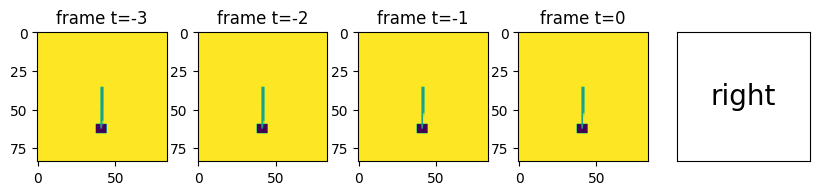

In [833]:
rows = 15
cols = 5
plt.figure(figsize=(10, rows*2))
for i in range(1):
    image = X_train_replay[0]
    action = np.argmax(predictions)
    plt.subplot(rows, cols, i*cols+1)
    plt.imshow(image[:, :, 0])
    plt.title("frame t=-3")

    plt.subplot(rows, cols, i*cols+2)
    plt.imshow(image[:, :, 1])
    plt.title("frame t=-2")

    plt.subplot(rows, cols, i*cols+3)
    plt.imshow(image[:, :, 2])
    plt.title("frame t=-1")

    plt.subplot(rows, cols, i*cols+4)
    plt.imshow(image[:, :, 3])
    plt.title("frame t=0")

    # Create a subplot with a single plot
    plt.subplot(rows, cols, i*cols+5)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.text(0.5, 0.5, action_to_str(
        np.argmax(y_train_replay[0])), fontsize=20, ha='center', va='center')
    plt.xticks([])
    plt.yticks([])

## Test Loop

In [20]:
def add_frame_to_frame_stack(frame_stack, new_frame):
    """Move `frame_stack[:,:,4]` to `frame_stack[:,:,3]` and move `frame_stack[:,:,3]` to `frame_stack[:,:,2]` etc.. Next put `new_frame` in `frame_stack[:,:,4]`"""
    frame_stack[:, :, 0] = frame_stack[:, :, 1]
    frame_stack[:, :, 1] = frame_stack[:, :, 2]
    frame_stack[:, :, 2] = frame_stack[:, :, 3]
    frame_stack[:, :, 3] = new_frame
    return frame_stack

# Training parameters
episodes = 100  # amount of times we try to beat the game // 50 might be enough
exploration_rate = 1  # Exploration rate - We don't need this because during this training loop we will always sample and do random actions
avg_score = 0
scores = []
X_train = None


img1 = np.random.random((84, 84))
img2 = np.random.random((84, 84))
img3 = np.random.random((84, 84))
img4 = np.random.random((84, 84))
frame_stack = np.stack([img1, img2, img3, img4], axis=2)
episode_frames = []  # all frames of a single episode
episode_actions = []  # all actions of a single episode

# Main training loop
for episode in range(episodes):
    # reset run
    state = env.reset()
    state = get_preprocessed_frame(env=env)
    frame_stack = add_frame_to_frame_stack(
        frame_stack=frame_stack, new_frame=state)
    frame_stack = add_frame_to_frame_stack(
        frame_stack=frame_stack, new_frame=state)
    frame_stack = add_frame_to_frame_stack(
        frame_stack=frame_stack, new_frame=state)
    frame_stack = add_frame_to_frame_stack(
        frame_stack=frame_stack, new_frame=state)
    score = 0

    # game loop - when the game loop starts score=0. we use score to see in which frame we currently are. So score>4 means if we are on the 6th frame of the game
    while True:
        # first we need to make sure the frame_stack and action_stack both have their queue filled up.
        # GET STATE
        # preprocess state 1/2
        state = get_preprocessed_frame(env=env)
        # add frame to frame stack
        frame_stack = add_frame_to_frame_stack(frame_stack=frame_stack, new_frame=state)
        episode_frames.append(state)
        # preprocess state 2/2
        frame_stack_copy = frame_stack.copy()
        # add dimention to shape so the model can make a prediction. (without this step the model will get a shape error becayse there is no batch, this code makes batch=1)
        frame_stack_copy = np.expand_dims(frame_stack_copy, axis=0)

        # GET ACTION
        # action = env.action_space.sample()
        episode_actions.append(action)
        q_values = model4.predict(frame_stack_copy)
        action = np.argmax(q_values)

        # DO ACTION
        _, reward, dead, info, truncated = env.step(action)

        # +1 score
        score += 1
        if dead:
            break
        
    # print score
    print(f'Episode:{episode+1} Score:{score}')
    avg_score += score
    scores.append(score)

# print average score
print(f"Average Score: {avg_score/episodes}")
print(f"Max Score: {np.max(scores)}")
env.close()

1/1 [==============================] - 0s 81ms/step
total frames: 10
total actions: 10
Episode:1 Score:10
1/1 [==============================] - 0s 77ms/step
total frames: 19
total actions: 19
Episode:2 Score:9
1/1 [==============================] - 0s 77ms/step
total frames: 28
total actions: 28
Episode:3 Score:9
1/1 [==============================] - 0s 85ms/step
total frames: 36
total actions: 36
Episode:4 Score:8
1/1 [==============================] - 0s 88ms/step
total frames: 45
total actions: 45
Episode:5 Score:9
1/1 [==============================] - 0s 83ms/step
total frames: 55
total actions: 55
Episode:6 Score:10
1/1 [==============================] - 0s 85ms/step
total frames: 65
total actions: 65
Episode:7 Score:10
1/1 [==============================] - 0s 81ms/step
total frames: 75
total actions: 75
Episode:8 Score:10
1/1 [==============================] - 0s 86ms/step
total frames: 85
total actions: 85
Episode:9 Score:10
1/1 [==============================] - 0s 83ms/ste

In [853]:
model4.save('./models/4-frame')

INFO:tensorflow:Assets written to: ./models/4-frame\assets


INFO:tensorflow:Assets written to: ./models/4-frame\assets


<div style='background-color:yellow;font-size:80px;color:black;text-align:center;padding-top:10px;padding-bottom:10px'>END</div>

In [854]:
print(854, 'is crazy')

854 is crazy
